In [230]:
# Read in datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

USA_train_imputed = pd.read_csv("USA_train.csv")
USA_test_imputed = pd.read_csv("USA_test.csv")
USA_train_imputed.set_index('date', inplace=True)
USA_test_imputed.set_index('date', inplace=True)

Brazil_train_imputed = pd.read_csv("Brazil_train.csv")
Brazil_test_imputed = pd.read_csv("Brazil_test.csv")
Brazil_train_imputed.set_index('date', inplace=True)
Brazil_test_imputed.set_index('date', inplace=True)

Germany_train_imputed = pd.read_csv("Germany_train.csv")
Germany_test_imputed = pd.read_csv("Germany_test.csv")
Germany_train_imputed.set_index('date', inplace=True)
Germany_test_imputed.set_index('date', inplace=True)

Nigeria_train_imputed = pd.read_csv("Nigeria_train.csv")
Nigeria_test_imputed = pd.read_csv("Nigeria_test.csv")
Nigeria_train_imputed.set_index('date', inplace=True)
Nigeria_test_imputed.set_index('date', inplace=True)

China_train_imputed = pd.read_csv("China_train.csv")
China_test_imputed = pd.read_csv("China_test.csv")
China_train_imputed.set_index('date', inplace=True)
China_test_imputed.set_index('date', inplace=True)

Australia_train_imputed = pd.read_csv("Australia_train.csv")
Australia_test_imputed = pd.read_csv("Australia_test.csv")
Australia_train_imputed.set_index('date', inplace=True)
Australia_test_imputed.set_index('date', inplace=True)

In [ ]:
# Results Initially Bad. Add Lag1 and Lag2 Columns. Still not great.

In [231]:
USA_train_imputed['new_cases_Lag_1'] = USA_train_imputed['new_cases'].shift(1)
USA_train_imputed['new_cases_Lag_2'] = USA_train_imputed['new_cases'].shift(2)

USA_test_imputed['new_cases_Lag_1'] = USA_test_imputed['new_cases'].shift(1)
USA_test_imputed['new_cases_Lag_2'] = USA_test_imputed['new_cases'].shift(2)

### USA

In [232]:
import xgboost as xgb
model = xgb.XGBRegressor()

# Drop Columns that are constant for all dates as they will have no effect on data
# Fix Lag Columns so values at beginning ar 0 not NaN and values in test dataset are those of last values in train
USA_multivariate_train_imputed = USA_train_imputed
USA_multivariate_train_imputed = USA_multivariate_train_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                             'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
USA_multivariate_train_imputed['new_cases_Lag_7'] = USA_multivariate_train_imputed ['new_cases_Lag_7'].fillna(0)
USA_multivariate_train_imputed['new_cases_Lag_14'] = USA_multivariate_train_imputed ['new_cases_Lag_14'].fillna(0)
USA_multivariate_train_imputed['new_cases_Lag_1'] = USA_multivariate_train_imputed ['new_cases_Lag_1'].fillna(0)
USA_multivariate_train_imputed['new_cases_Lag_2'] = USA_multivariate_train_imputed ['new_cases_Lag_2'].fillna(0)
USA_multivariate_train_imputed["Weekend"] = USA_multivariate_train_imputed["Weekend"].astype(int)


USA_multivariate_test_imputed = USA_test_imputed
USA_multivariate_test_imputed = USA_multivariate_test_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
USA_multivariate_test_imputed['new_cases_Lag_7'][0:7] = USA_multivariate_train_imputed['new_cases'][-7:]
USA_multivariate_test_imputed['new_cases_Lag_14'][0:14] = USA_multivariate_train_imputed['new_cases'][-14:]
USA_multivariate_test_imputed['new_cases_Lag_1'][0:1] = USA_multivariate_train_imputed['new_cases'][-1:]
USA_multivariate_test_imputed['new_cases_Lag_2'][0:2] = USA_multivariate_train_imputed['new_cases'][-2:]
USA_multivariate_test_imputed["Weekend"] = USA_multivariate_test_imputed["Weekend"].astype(int)

In [233]:
# Split train/test into X and Y
Y_data_TRAIN_USA_XGB = USA_multivariate_train_imputed['new_cases']
X_data_TRAIN_USA_XGB = USA_multivariate_train_imputed.drop(columns = ['new_cases'])
Y_data_TEST_USA_XGB = USA_multivariate_test_imputed['new_cases']
X_data_TEST_USA_XGB = USA_multivariate_test_imputed.drop(columns = ['new_cases'])

In [234]:
# Scale Data
scalerX = StandardScaler().fit(X_data_TRAIN_USA_XGB)
X_data_TRAIN_USA_XGB_scaled = scalerX.transform(X_data_TRAIN_USA_XGB)
X_data_TEST_USA_XGB_scaled = scalerX.transform(X_data_TEST_USA_XGB)

In [235]:
# Grid Search Parameters
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1,2,4,5,10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [236]:
# Conduct Grid Search
grid_search.fit(X_data_TRAIN_USA_XGB_scaled, Y_data_TRAIN_USA_XGB)
print(grid_search.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}


In [237]:
best_model = grid_search.best_estimator_

In [238]:
# Fit model
best_model.fit(X_data_TRAIN_USA_XGB_scaled, Y_data_TRAIN_USA_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [239]:
# Train Predictions and Train RMSE
USA_train_predictions_xgb = best_model.predict(X_data_TRAIN_USA_XGB_scaled)
rmse = np.sqrt(mean_squared_error(USA_train_predictions_xgb, Y_data_TRAIN_USA_XGB))
rmse

21089.456283635558

<AxesSubplot:xlabel='date'>

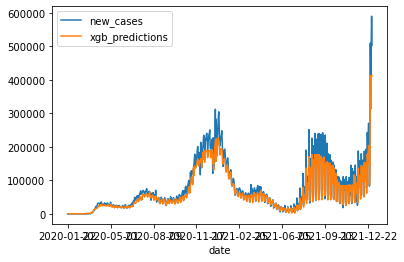

In [240]:
USA_train_imputed['xgb_predictions'] = USA_train_predictions_xgb
USA_train_imputed.plot(y=["new_cases", "xgb_predictions"])

In [241]:
# TEST PREDICTIONS AND RMSE
USA_predictions_xgb = best_model.predict(X_data_TEST_USA_XGB_scaled)
rmse = np.sqrt(mean_squared_error(USA_predictions_xgb, Y_data_TEST_USA_XGB))
rmse

297408.05178849667

<AxesSubplot:xlabel='date'>

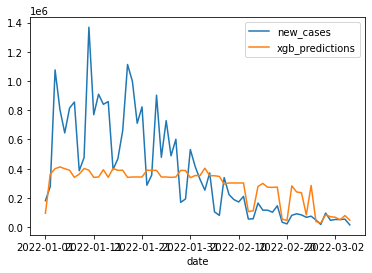

In [242]:
USA_test_imputed['xgb_predictions'] = USA_predictions_xgb
USA_test_imputed.plot(y=["new_cases", "xgb_predictions"])

In [243]:
# What Predictors were used?
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_data_TRAIN_USA_XGB.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                       Feature  Importance
32                             new_cases_Lag_7    0.519454
1                     total_deaths_per_million    0.188946
11                               positive_rate    0.071226
34                      Rolling_Mean_new_cases    0.044283
33                            new_cases_Lag_14    0.021530
30              new_people_vaccinated_smoothed    0.020029
36                             new_cases_Lag_1    0.019830
6                                    new_tests    0.018766
17                               hosp_patients    0.016699
29  new_people_vaccinated_smoothed_per_hundred    0.015170
13                          new_tests_smoothed    0.011598
19          weekly_hosp_admissions_per_million    0.009012
9                          new_deaths_smoothed    0.008915
2                                   new_deaths    0.007894
28                   new_vaccinations_smoothed    0.007835
35                                     Weekend    0.0072

### BRAZIL

In [167]:
# Drop Columns that are constant for all dates as they will have no effect on data
# Fix Lag Columns so values at beginning ar 0 not NaN and values in test dataset are those of last values in train
Brazil_multivariate_train_imputed = Brazil_train_imputed
Brazil_multivariate_train_imputed = Brazil_multivariate_train_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                             'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Brazil_multivariate_train_imputed['new_cases_Lag_7'] = Brazil_multivariate_train_imputed ['new_cases_Lag_7'].fillna(0)
Brazil_multivariate_train_imputed['new_cases_Lag_14'] = Brazil_multivariate_train_imputed ['new_cases_Lag_14'].fillna(0)
Brazil_multivariate_train_imputed["Weekend"] = Brazil_multivariate_train_imputed["Weekend"].astype(int)


Brazil_multivariate_test_imputed = Brazil_test_imputed
Brazil_multivariate_test_imputed = Brazil_multivariate_test_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate','new_cases_smoothed',
                                                                           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Brazil_multivariate_test_imputed['new_cases_Lag_7'][0:7] = Brazil_multivariate_train_imputed['new_cases'][-7:]
Brazil_multivariate_test_imputed['new_cases_Lag_14'][0:14] = Brazil_multivariate_train_imputed['new_cases'][-14:]
Brazil_multivariate_test_imputed["Weekend"] = Brazil_multivariate_test_imputed["Weekend"].astype(int)

In [168]:
# Split train/test into X and Y
Y_data_TRAIN_Brazil_XGB = Brazil_multivariate_train_imputed['new_cases']
X_data_TRAIN_Brazil_XGB = Brazil_multivariate_train_imputed.drop(columns = ['new_cases'])
Y_data_TEST_Brazil_XGB = Brazil_multivariate_test_imputed['new_cases']
X_data_TEST_Brazil_XGB = Brazil_multivariate_test_imputed.drop(columns = ['new_cases'])

# Scale Data
scalerX = StandardScaler().fit(X_data_TRAIN_Brazil_XGB)
X_data_TRAIN_Brazil_XGB_scaled = scalerX.transform(X_data_TRAIN_Brazil_XGB)
X_data_TEST_Brazil_XGB_scaled = scalerX.transform(X_data_TEST_Brazil_XGB)

# Grid Search Parameters
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1,2,4,5,10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [169]:
# Conduct Grid Search
grid_search.fit(X_data_TRAIN_Brazil_XGB_scaled, Y_data_TRAIN_Brazil_XGB)
print(grid_search.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}


In [170]:
best_model = grid_search.best_estimator_
# Fit model
best_model.fit(X_data_TRAIN_Brazil_XGB_scaled, Y_data_TRAIN_Brazil_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [171]:
# Train Predictions and Train RMSE
Brazil_train_predictions_xgb = best_model.predict(X_data_TRAIN_Brazil_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Brazil_train_predictions_xgb, Y_data_TRAIN_Brazil_XGB))
rmse

680.4342454818282

<AxesSubplot:xlabel='date'>

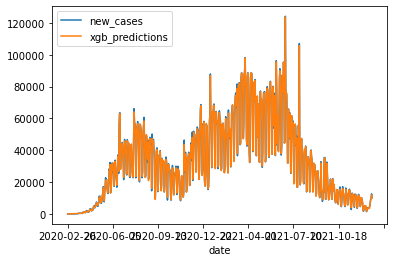

In [172]:
Brazil_train_imputed['xgb_predictions'] = Brazil_train_predictions_xgb
Brazil_train_imputed.plot(y=["new_cases", "xgb_predictions"])

In [173]:
# TEST PREDICTIONS AND RMSE
Brazil_predictions_xgb = best_model.predict(X_data_TEST_Brazil_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Brazil_predictions_xgb, Y_data_TEST_Brazil_XGB))
rmse

91848.84580432872

<AxesSubplot:xlabel='date'>

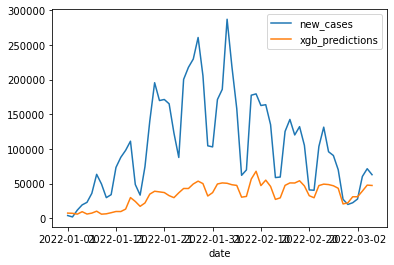

In [174]:
Brazil_test_imputed['xgb_predictions'] = Brazil_predictions_xgb
Brazil_test_imputed.plot(y=["new_cases", "xgb_predictions"])

In [175]:
# What Predictors were used?
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_data_TRAIN_Brazil_XGB.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                       Feature  Importance
20                             new_cases_Lag_7    0.699681
1                       new_deaths_per_million    0.123813
21                            new_cases_Lag_14    0.068076
22                      Rolling_Mean_new_cases    0.021868
9                     total_tests_per_thousand    0.016453
2                     total_deaths_per_million    0.015575
11                   new_vaccinations_smoothed    0.013447
5                          new_deaths_smoothed    0.010101
13              new_people_vaccinated_smoothed    0.008535
7                           new_tests_smoothed    0.007462
17                            new_vaccinations    0.006061
0                             stringency_index    0.003975
23                                     Weekend    0.002903
18                           people_vaccinated    0.001601
15                          total_vaccinations    0.000450
10                                 total_tests    0.0000

### GERMANY

In [176]:
# Drop Columns that are constant for all dates as they will have no effect on data
# Fix Lag Columns so values at beginning ar 0 not NaN and values in test dataset are those of last values in train
Germany_multivariate_train_imputed = Germany_train_imputed
Germany_multivariate_train_imputed = Germany_multivariate_train_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand', 'new_cases_smoothed',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate',
                                                                             'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Germany_multivariate_train_imputed['new_cases_Lag_7'] = Germany_multivariate_train_imputed ['new_cases_Lag_7'].fillna(0)
Germany_multivariate_train_imputed['new_cases_Lag_14'] = Germany_multivariate_train_imputed ['new_cases_Lag_14'].fillna(0)
Germany_multivariate_train_imputed["Weekend"] = Germany_multivariate_train_imputed["Weekend"].astype(int)


Germany_multivariate_test_imputed = Germany_test_imputed
Germany_multivariate_test_imputed = Germany_multivariate_test_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Germany_multivariate_test_imputed['new_cases_Lag_7'][0:7] = Germany_multivariate_train_imputed['new_cases'][-7:]
Germany_multivariate_test_imputed['new_cases_Lag_14'][0:14] = Germany_multivariate_train_imputed['new_cases'][-14:]
Germany_multivariate_test_imputed["Weekend"] = Germany_multivariate_test_imputed["Weekend"].astype(int)

In [177]:
# Split train/test into X and Y
Y_data_TRAIN_Germany_XGB = Germany_multivariate_train_imputed['new_cases']
X_data_TRAIN_Germany_XGB = Germany_multivariate_train_imputed.drop(columns = ['new_cases'])
Y_data_TEST_Germany_XGB = Germany_multivariate_test_imputed['new_cases']
X_data_TEST_Germany_XGB = Germany_multivariate_test_imputed.drop(columns = ['new_cases'])

# Scale Data
scalerX = StandardScaler().fit(X_data_TRAIN_Germany_XGB)
X_data_TRAIN_Germany_XGB_scaled = scalerX.transform(X_data_TRAIN_Germany_XGB)
X_data_TEST_Germany_XGB_scaled = scalerX.transform(X_data_TEST_Germany_XGB)

# Grid Search Parameters
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1,2,4,5,10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [178]:
# Conduct Grid Search
grid_search.fit(X_data_TRAIN_Germany_XGB_scaled, Y_data_TRAIN_Germany_XGB)
print(grid_search.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}


In [179]:
best_model = grid_search.best_estimator_
# Fit model
best_model.fit(X_data_TRAIN_Germany_XGB_scaled, Y_data_TRAIN_Germany_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [180]:
# Train Predictions and Train RMSE
Germany_train_predictions_xgb = best_model.predict(X_data_TRAIN_Germany_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Germany_train_predictions_xgb, Y_data_TRAIN_Germany_XGB))
rmse

2759.0790534410767

<AxesSubplot:xlabel='date'>

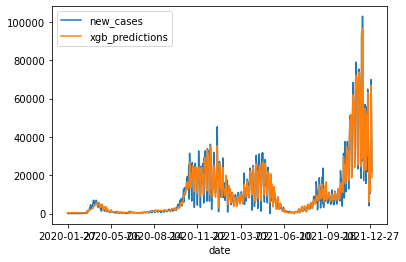

In [181]:
Germany_train_imputed['xgb_predictions'] = Germany_train_predictions_xgb
Germany_train_imputed.plot(y=["new_cases", "xgb_predictions"])

In [182]:
# TEST PREDICTIONS AND RMSE
Germany_predictions_xgb = best_model.predict(X_data_TEST_Germany_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Germany_predictions_xgb, Y_data_TEST_Germany_XGB))
rmse

114343.36778613318

<AxesSubplot:xlabel='date'>

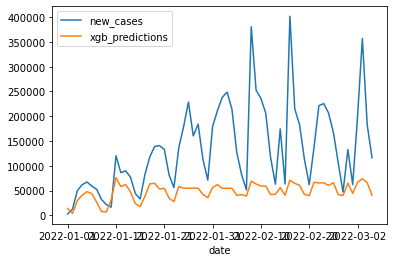

In [183]:
Germany_test_imputed['xgb_predictions'] = Germany_predictions_xgb
Germany_test_imputed.plot(y=["new_cases", "xgb_predictions"])

In [184]:
# What Predictors were used?
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_data_TRAIN_Germany_XGB.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                       Feature  Importance
26                             new_cases_Lag_7    0.488192
3                                 total_deaths    0.140686
28                      Rolling_Mean_new_cases    0.101502
9                           new_tests_smoothed    0.088028
27                            new_cases_Lag_14    0.063978
5                                   new_deaths    0.037106
0                             stringency_index    0.022439
21                   new_vaccinations_smoothed    0.013142
20       new_vaccinations_smoothed_per_million    0.010271
22                            new_vaccinations    0.009874
11             new_deaths_smoothed_per_million    0.007327
23              new_people_vaccinated_smoothed    0.006309
7                     icu_patients_per_million    0.004928
1                       weekly_hosp_admissions    0.003586
19  new_people_vaccinated_smoothed_per_hundred    0.002631
25                              total_boosters    0.0000

### NIGERIA

In [185]:
# Drop Columns that are constant for all dates as they will have no effect on data
# Fix Lag Columns so values at beginning ar 0 not NaN and values in test dataset are those of last values in train
Nigeria_multivariate_train_imputed = Nigeria_train_imputed
Nigeria_multivariate_train_imputed = Nigeria_multivariate_train_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita',
                                                                              'cardiovasc_death_rate',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                             'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Nigeria_multivariate_train_imputed['new_cases_Lag_7'] = Nigeria_multivariate_train_imputed ['new_cases_Lag_7'].fillna(0)
Nigeria_multivariate_train_imputed['new_cases_Lag_14'] = Nigeria_multivariate_train_imputed ['new_cases_Lag_14'].fillna(0)
Nigeria_multivariate_train_imputed["Weekend"] = Nigeria_multivariate_train_imputed["Weekend"].astype(int)


Nigeria_multivariate_test_imputed = Nigeria_test_imputed
Nigeria_multivariate_test_imputed = Nigeria_multivariate_test_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita',
                                                                              'cardiovasc_death_rate',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Nigeria_multivariate_test_imputed['new_cases_Lag_7'][0:7] = Nigeria_multivariate_train_imputed['new_cases'][-7:]
Nigeria_multivariate_test_imputed['new_cases_Lag_14'][0:14] = Nigeria_multivariate_train_imputed['new_cases'][-14:]
Nigeria_multivariate_test_imputed["Weekend"] = Nigeria_multivariate_test_imputed["Weekend"].astype(int)

In [186]:
# Split train/test into X and Y
Y_data_TRAIN_Nigeria_XGB = Nigeria_multivariate_train_imputed['new_cases']
X_data_TRAIN_Nigeria_XGB = Nigeria_multivariate_train_imputed.drop(columns = ['new_cases'])
Y_data_TEST_Nigeria_XGB = Nigeria_multivariate_test_imputed['new_cases']
X_data_TEST_Nigeria_XGB = Nigeria_multivariate_test_imputed.drop(columns = ['new_cases'])

# Scale Data
scalerX = StandardScaler().fit(X_data_TRAIN_Nigeria_XGB)
X_data_TRAIN_Nigeria_XGB_scaled = scalerX.transform(X_data_TRAIN_Nigeria_XGB)
X_data_TEST_Nigeria_XGB_scaled = scalerX.transform(X_data_TEST_Nigeria_XGB)

# Grid Search Parameters
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1,2,4,5,10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [187]:
# Conduct Grid Search
grid_search.fit(X_data_TRAIN_Nigeria_XGB_scaled, Y_data_TRAIN_Nigeria_XGB)
print(grid_search.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 500}


In [188]:
best_model = grid_search.best_estimator_
# Fit model
best_model.fit(X_data_TRAIN_Nigeria_XGB_scaled, Y_data_TRAIN_Nigeria_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [189]:
# Train Predictions and Train RMSE
Nigeria_train_predictions_xgb = best_model.predict(X_data_TRAIN_Nigeria_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Nigeria_train_predictions_xgb, Y_data_TRAIN_Nigeria_XGB))
rmse

140.58629450572474

<AxesSubplot:xlabel='date'>

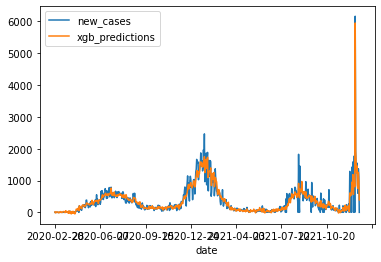

In [190]:
Nigeria_train_imputed['xgb_predictions'] = Nigeria_train_predictions_xgb
Nigeria_train_imputed.plot(y=["new_cases", "xgb_predictions"])

In [191]:
# TEST PREDICTIONS AND RMSE
Nigeria_predictions_xgb = best_model.predict(X_data_TEST_Nigeria_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Nigeria_predictions_xgb, Y_data_TEST_Nigeria_XGB))
rmse

3465.3317039915096

<AxesSubplot:xlabel='date'>

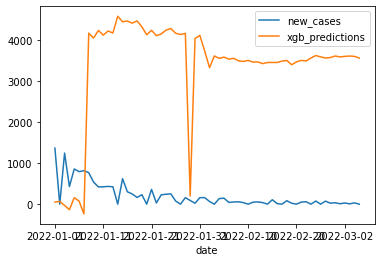

In [192]:
Nigeria_test_imputed['xgb_predictions'] = Nigeria_predictions_xgb
Nigeria_test_imputed.plot(y=["new_cases", "xgb_predictions"])

In [193]:
# What Predictors were used?
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_data_TRAIN_Nigeria_XGB.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                       Feature  Importance
18                      Rolling_Mean_new_cases    0.580045
12                   new_vaccinations_smoothed    0.127076
16                             new_cases_Lag_7    0.111841
9                                positive_rate    0.068489
14              new_people_vaccinated_smoothed    0.024556
10                          new_tests_smoothed    0.021053
4                                   new_deaths    0.014898
2                     total_deaths_per_million    0.011191
19                                     Weekend    0.010505
1                             stringency_index    0.008167
6                          new_deaths_smoothed    0.007500
17                            new_cases_Lag_14    0.006340
8                               tests_per_case    0.004221
13  new_people_vaccinated_smoothed_per_hundred    0.004119
11             new_tests_smoothed_per_thousand    0.000000
7              new_deaths_smoothed_per_million    0.0000

### CHINA

In [205]:
# Drop Columns that are constant for all dates as they will have no effect on data
# Fix Lag Columns so values at beginning ar 0 not NaN and values in test dataset are those of last values in train
China_multivariate_train_imputed = China_train_imputed
China_multivariate_train_imputed = China_multivariate_train_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                             'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
China_multivariate_train_imputed['new_cases_Lag_7'] = China_multivariate_train_imputed ['new_cases_Lag_7'].fillna(0)
China_multivariate_train_imputed['new_cases_Lag_14'] = China_multivariate_train_imputed ['new_cases_Lag_14'].fillna(0)
China_multivariate_train_imputed["Weekend"] = China_multivariate_train_imputed["Weekend"].astype(int)


China_multivariate_test_imputed = China_test_imputed
China_multivariate_test_imputed = China_multivariate_test_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
China_multivariate_test_imputed['new_cases_Lag_7'][0:7] = China_multivariate_train_imputed['new_cases'][-7:]
China_multivariate_test_imputed['new_cases_Lag_14'][0:14] = China_multivariate_train_imputed['new_cases'][-14:]
China_multivariate_test_imputed["Weekend"] = China_multivariate_test_imputed["Weekend"].astype(int)

In [206]:
# Split train/test into X and Y
Y_data_TRAIN_China_XGB = China_multivariate_train_imputed['new_cases']
X_data_TRAIN_China_XGB = China_multivariate_train_imputed.drop(columns = ['new_cases'])
Y_data_TEST_China_XGB = China_multivariate_test_imputed['new_cases']
X_data_TEST_China_XGB = China_multivariate_test_imputed.drop(columns = ['new_cases'])

# Scale Data
scalerX = StandardScaler().fit(X_data_TRAIN_China_XGB)
X_data_TRAIN_China_XGB_scaled = scalerX.transform(X_data_TRAIN_China_XGB)
X_data_TEST_China_XGB_scaled = scalerX.transform(X_data_TEST_China_XGB)

# Grid Search Parameters
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1,2,4,5,10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [207]:
# Conduct Grid Search
grid_search.fit(X_data_TRAIN_China_XGB_scaled, Y_data_TRAIN_China_XGB)
print(grid_search.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}


In [208]:
best_model = grid_search.best_estimator_
# Fit model
best_model.fit(X_data_TRAIN_China_XGB_scaled, Y_data_TRAIN_China_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [209]:
# Train Predictions and Train RMSE
China_train_predictions_xgb = best_model.predict(X_data_TRAIN_China_XGB_scaled)
rmse = np.sqrt(mean_squared_error(China_train_predictions_xgb, Y_data_TRAIN_China_XGB))
rmse

118.98148813821891

<AxesSubplot:xlabel='date'>

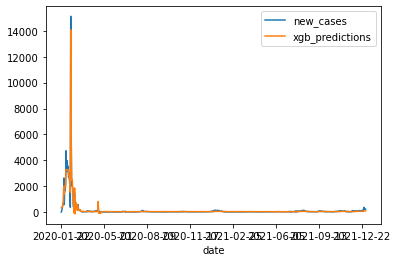

In [210]:
China_train_imputed['xgb_predictions'] = China_train_predictions_xgb
China_train_imputed.plot(y=["new_cases", "xgb_predictions"])

In [211]:
# TEST PREDICTIONS AND RMSE
China_predictions_xgb = best_model.predict(X_data_TEST_China_XGB_scaled)
rmse = np.sqrt(mean_squared_error(China_predictions_xgb, Y_data_TEST_China_XGB))
rmse

90.52037125960427

<AxesSubplot:xlabel='date'>

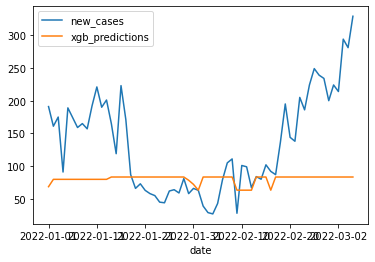

In [212]:
China_test_imputed['xgb_predictions'] = China_predictions_xgb
China_test_imputed.plot(y=["new_cases", "xgb_predictions"])

In [213]:
# What Predictors were used?
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_data_TRAIN_China_XGB.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                  Feature  Importance
1                total_deaths_per_million    0.336522
3                  new_deaths_per_million    0.243444
14                 Rolling_Mean_new_cases    0.157141
12                        new_cases_Lag_7    0.139939
5         new_deaths_smoothed_per_million    0.090952
13                       new_cases_Lag_14    0.023197
9                      total_vaccinations    0.008804
0                        stringency_index    0.000000
2                            total_deaths    0.000000
4                              new_deaths    0.000000
6                     new_deaths_smoothed    0.000000
7               new_vaccinations_smoothed    0.000000
8   new_vaccinations_smoothed_per_million    0.000000
10         total_vaccinations_per_hundred    0.000000
11                       new_vaccinations    0.000000
15                                Weekend    0.000000


### AUSTRALIA

In [214]:
# Drop Columns that are constant for all dates as they will have no effect on data
# Fix Lag Columns so values at beginning ar 0 not NaN and values in test dataset are those of last values in train
Australia_multivariate_train_imputed = Australia_train_imputed
Australia_multivariate_train_imputed = Australia_multivariate_train_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                             'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Australia_multivariate_train_imputed['new_cases_Lag_7'] = Australia_multivariate_train_imputed ['new_cases_Lag_7'].fillna(0)
Australia_multivariate_train_imputed['new_cases_Lag_14'] = Australia_multivariate_train_imputed ['new_cases_Lag_14'].fillna(0)
Australia_multivariate_train_imputed["Weekend"] = Australia_multivariate_train_imputed["Weekend"].astype(int)


Australia_multivariate_test_imputed = Australia_test_imputed
Australia_multivariate_test_imputed = Australia_multivariate_test_imputed.drop(columns=['iso_code', 'population_density'
                                                                             ,'median_age', 'aged_65_older', 'aged_70_older',
                                                                             'gdp_per_capita','extreme_poverty',
                                                                              'cardiovasc_death_rate','hospital_beds_per_thousand',
                                                                             'life_expectancy','human_development_index','total_cases',
                                                                             'location', 'continent', 'population', 'reproduction_rate', 'new_cases_smoothed',
                                                                           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'])
Australia_multivariate_test_imputed['new_cases_Lag_7'][0:7] = Australia_multivariate_train_imputed['new_cases'][-7:]
Australia_multivariate_test_imputed['new_cases_Lag_14'][0:14] = Australia_multivariate_train_imputed['new_cases'][-14:]
Australia_multivariate_test_imputed["Weekend"] = Australia_multivariate_test_imputed["Weekend"].astype(int)

In [215]:
# Split train/test into X and Y
Y_data_TRAIN_Australia_XGB = Australia_multivariate_train_imputed['new_cases']
X_data_TRAIN_Australia_XGB = Australia_multivariate_train_imputed.drop(columns = ['new_cases'])
Y_data_TEST_Australia_XGB = Australia_multivariate_test_imputed['new_cases']
X_data_TEST_Australia_XGB = Australia_multivariate_test_imputed.drop(columns = ['new_cases'])

# Scale Data
scalerX = StandardScaler().fit(X_data_TRAIN_Australia_XGB)
X_data_TRAIN_Australia_XGB_scaled = scalerX.transform(X_data_TRAIN_Australia_XGB)
X_data_TEST_Australia_XGB_scaled = scalerX.transform(X_data_TEST_Australia_XGB)

# Grid Search Parameters
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [1,2,4,5,10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [216]:
# Conduct Grid Search
grid_search.fit(X_data_TRAIN_Australia_XGB_scaled, Y_data_TRAIN_Australia_XGB)
print(grid_search.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}


In [217]:
best_model = grid_search.best_estimator_
# Fit model
best_model.fit(X_data_TRAIN_Australia_XGB_scaled, Y_data_TRAIN_Australia_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [220]:
# Train Predictions and Train RMSE
Australia_train_predictions_xgb = best_model.predict(X_data_TRAIN_Australia_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Australia_train_predictions_xgb, Y_data_TRAIN_Australia_XGB))
rmse

41.50093183651759

<AxesSubplot:xlabel='date'>

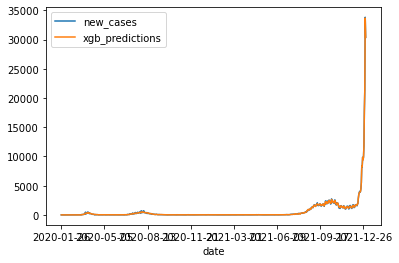

In [221]:
Australia_train_imputed['xgb_predictions'] = Australia_train_predictions_xgb
Australia_train_imputed.plot(y=["new_cases", "xgb_predictions"])

In [222]:
# TEST PREDICTIONS AND RMSE
Australia_predictions_xgb = best_model.predict(X_data_TEST_Australia_XGB_scaled)
rmse = np.sqrt(mean_squared_error(Australia_predictions_xgb, Y_data_TEST_Australia_XGB))
rmse

35343.77304077213

<AxesSubplot:xlabel='date'>

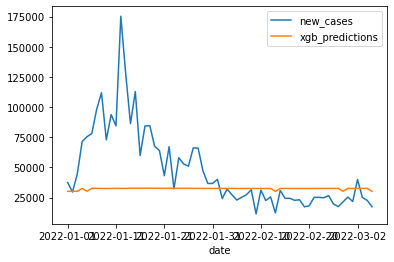

In [223]:
Australia_test_imputed['xgb_predictions'] = Australia_predictions_xgb
Australia_test_imputed.plot(y=["new_cases", "xgb_predictions"])

In [224]:
# What Predictors were used?
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_data_TRAIN_Australia_XGB.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                       Feature  Importance
1                     total_deaths_per_million    0.702236
30                             new_cases_Lag_7    0.197605
32                      Rolling_Mean_new_cases    0.067624
5                     total_tests_per_thousand    0.009284
9                           new_tests_smoothed    0.008322
11                               positive_rate    0.005278
7                                    new_tests    0.003599
3                                   new_deaths    0.002095
15                    icu_patients_per_million    0.000767
31                            new_cases_Lag_14    0.000468
16                               hosp_patients    0.000419
12                              tests_per_case    0.000404
13             new_deaths_smoothed_per_million    0.000378
33                                     Weekend    0.000353
21              new_people_vaccinated_smoothed    0.000327
0                             stringency_index    0.0003